# DQNとは何か

今回は深層強化学習の初歩までを紹介します。特に、Q-learningという強化学習アルゴリズムで解決するという問題をやってみましょう。

## A. 深層強化学習入門

行動価値関数は、ビニングすることで配列として表現されましたが、関数近似することで表現するのも一つの手です。この関数近似に深層ニューラルネットワークを用い、この関数をQ-学習しようという考え方があります。これが**深層Q-学習**です。

今回、行動価値関数、入力層が1変数（センサーが観測した温度）、出力層が行動の2変数を持つ深層ニューラルネットワークを準備し、出力層の各ユニットには状態$s$で行動$a$を取った場合にその後得られる報酬の合計を出力するようにします。これは、$r_t+\gamma\max_{a}(Q(s_{t+1},a))$を出力にするようなニューラルネットワークを学習することに近似的に等しくなります。この値に近くなるようにネットワークの重みをback propagationで更新します。

In [1]:
# import文
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from environment import EnvSensor
from reward import Reward
from utils import stop_episode, plot_demo

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import Huber
from collections import deque

## B. Q-Networkの実装

### モデルの実装

In [2]:
def DNN():
    model = Sequential()
    model.add(Dense(8, activation = "relu", input_dim = 1))
    model.add(Dense(8, activation = "relu"))
    model.add(Dense(units = 2, activation= "linear"))
    model.compile(loss = Huber(), optimizer = "adam")
    return model

DQNでは、センサーで観測した温度（状態）$s_{t}$ から行動 $a_{t}$ の価値を計算する関数、要するに行動価値関数をニューラルネットワークで定義します。今回は、3層ニューラルネットワークを用いて実装していきましょう。

In [3]:
class QNetwork():
    def __init__(self):
        self.model = DNN()
 
    # QNetworkの学習アルゴリズム
    def replay(self, memory, batch_size, gamma):
        inputs = np.zeros((batch_size, 1))
        targets = np.zeros((batch_size, 2))
        mini_batch = memory.sample(batch_size)
 
        for i, (state_b, action_b, reward_b, next_state_b) in enumerate(mini_batch):
            inputs[i:i+1] = state_b / 125.0
            target = reward_b
            
            # Q-学習のTD誤差の計算
            target = reward_b + gamma * \
                np.max(self.model.predict(next_state_b / 125.0)[0])
            
            # 教師
            targets[i] = self.model.predict(state_b / 125.0)[0]
            targets[i][action_b] = target
        
        self.model.fit(inputs, targets, epochs = 1, verbose = 0)

### 経験再生（Experience Replay）

ニューラルネットワークは時系列の入力によって学習にbiasがかかることが知られています。そこで、$(s_t,a_t,r_t,s_{t+1})$をメモリに保存し後でランダムに学習することで、時系列相関を打ち消す工夫を行うことがあります。要するに、メモリからランダムにサンプリングしたデータによって、Q-Networkをバッチ学習します。これを経験再生（experience replay）といいます。

In [4]:
# Experience Replayを実現するMemoryクラス
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen = max_size)
 
    def add(self, experience):
        self.buffer.append(experience)
 
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size = batch_size, 
                               replace = False)
        return [self.buffer[ii] for ii in idx]
 
    def len(self):
        return len(self.buffer)

### 探索時の方策（$\epsilon$-greedy方策）の設計

あとは、これまで通りに状態行動価値を最大化するような行動を$\epsilon$-greedyに選べば良いという方策を立てれば、DQNの完成です。

In [5]:
# カートの状態に応じて行動を決定するActorクラス
class Actor():
    def get_action(self, state, epsilon, QN):
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(QN.model.predict(state / 125.0)[0])
        else:
            action = np.random.choice([0, 1]) 
 
        return action

それではやってみましょう。

## C. 実際の学習

In [6]:
n_episodes = 3000
n_actions = 120
env = EnvSensor()
rew = Reward()

In [7]:
# Qネットワークとメモリ、Actorの生成
QN = QNetwork()
memory = Memory()
actor = Actor()

In [8]:
for episode in tqdm(range(n_episodes)):
    env.reset()  # 環境を初期する。
    state = env.get_state(action = 0)    # 初期状態の観察
    cumsum_reward = 0
 
    for t in range(1, n_actions+1):
        action = actor.get_action(state = state, epsilon = 0.25, QN = QN)
        next_state = env.get_state(action)
        reward = rew.get_reward(state = next_state)
        cumsum_reward += reward
 
        memory.add((state, action, reward, next_state))     # メモリの更新
        state = next_state    # 状態の更新
 
        # Qネットワークの重みを学習（Experience Replay）
        if (memory.len() > 1):
            QN.replay(memory = memory, batch_size = 1, gamma = 0.95)
            
#    print("episode :" + str(episode) + " reward : " + str(cumsum_reward))

W0913 08:19:38.179122 24908 deprecation.py:323] From C:\Users\utaka.DESKTOP-NJPQUDQ\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


あとは学習したQ-Networkを用いて決定方策を作り、訓練には用いなかったデータで挙動を確認します。

In [9]:
# 得られた決定方策
class DQPolicy():
    def __init__(self, QN):
        self.QN = QN
    
    def get_action(self, state):
        return np.argmax(self.QN.model.predict(state / 125.0)[0])

Text(0.5, 0, 'number of success')

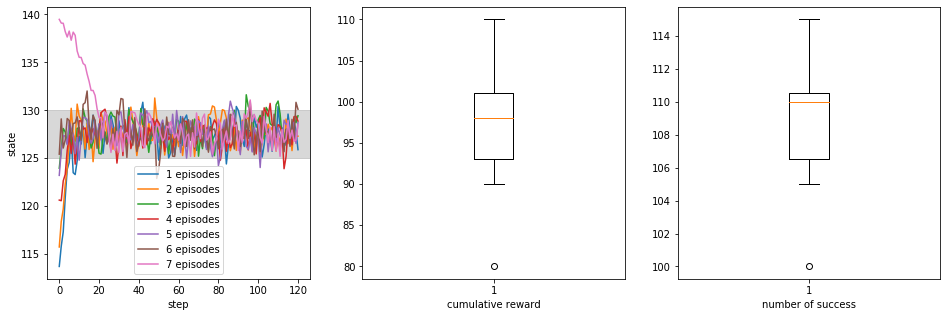

In [10]:
# 検証用のデータで挙動を確認する
pol = DQPolicy(QN = QN)
rew = Reward()

cumulative_rewards = []    # 累積報酬のhistory
n_success = np.zeros(shape = (7, ))    # 125℃以上130℃以下に温度を調節出来たstep数（120steps中）
fig, (axL, axM, axR) = plt.subplots(ncols = 3, figsize = (16, 5))
for i in range(7):
    rewards_in_episode = []
    states_history = np.asarray([])    # 現episodeでのstateのhistory
    state = env.reset()
    states_history = np.append(states_history, state)
    for j in range(120):
        action = pol.get_action(state)    # ε-greedyしない。
        state = env.get_state(action)
        rewards_in_episode.append(rew.get_reward(state))
        states_history = np.append(states_history, state)
        n_success[i] = np.sum((states_history >= 125) * (states_history <= 130))   # * <=> and
    cumulative_rewards.append(np.sum(rewards_in_episode))
    step_index = [j for j in range(120+1)]
    axL.plot(step_index, states_history, label = str(i+1) + " episodes")
axL.set_xlabel("step")
axL.set_ylabel("state")
axL.axhspan(ymin = 125.0, ymax = 130.0, color = "gray", alpha = 0.3)
axL.legend()
axM.boxplot(cumulative_rewards)
axM.set_xlabel("cumulative reward")
axR.boxplot(n_success)
axR.set_xlabel("number of success")

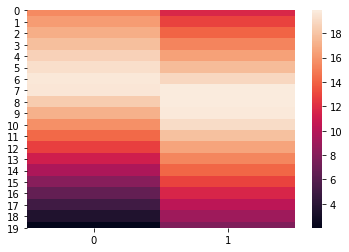

In [13]:
sns.heatmap(QN.model.predict(np.linspace(start = 120, stop = 140, num = 20) / 125.0))
plt.show()